# Training hybrid models using the Pennylane backend

In this example, we will first train a pure quantum model using PennyLane and PyTorch to classify whether a sentence is about cooking or computing. We will then train a hybrid model that takes in pairs of sentences and determines whether they are talking about the same or different topics.

In [1]:
BATCH_SIZE = 10
EPOCHS = 15
SEED = 2

In [2]:
import torch
import random
import numpy as np

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

### Read in the data and create diagrams

In [3]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('datasets/mc_dev_data.txt')
test_labels, test_data = read_data('datasets/mc_test_data.txt')

In [4]:
from lambeq import BobcatParser

reader = BobcatParser(verbose='text')

raw_train_diagrams = reader.sentences2diagrams(train_data)
raw_dev_diagrams = reader.sentences2diagrams(dev_data)
raw_test_diagrams = reader.sentences2diagrams(test_data)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


### Remove cups

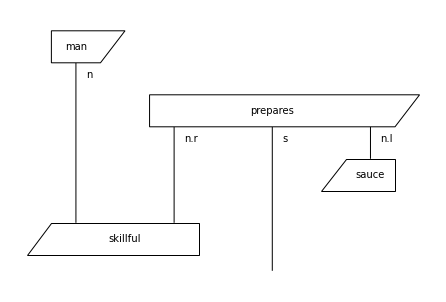

In [5]:
from lambeq import remove_cups

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

train_diagrams[0].draw()

### Create DisCoPy circuits

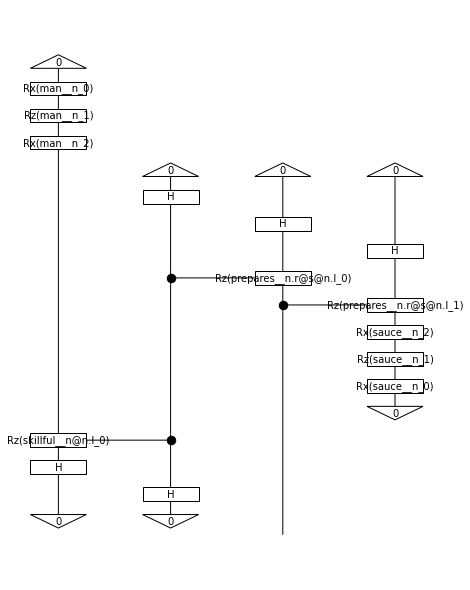

In [6]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(6, 8))

### Create (pure quantum) model and initialise parameters

In [7]:
from lambeq import PennyLaneModel

all_circuits = train_circuits + dev_circuits + test_circuits

model = PennyLaneModel.from_diagrams(all_circuits)
model.initialise_weights()
model = model.double()

### Prepare train dataset

In [8]:
from lambeq import Dataset

train_dataset = Dataset(train_circuits,
                        train_labels,
                        batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels)

### Training

##### Using `PytorchTrainer`

In [9]:
def acc(y_hat, y):
    return (torch.argmax(y_hat, dim=1) == 
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.mse_loss(y_hat, y.double())

In [10]:
from lambeq import PytorchTrainer

trainer = PytorchTrainer(
        model=model,
        loss_function=loss,
        optimizer=torch.optim.Adam,
        learning_rate=0.1,
        epochs=EPOCHS,
        evaluate_functions={"acc": acc},
        evaluate_on_train=True,
        use_tensorboard=False,
        verbose='text',
        seed=SEED
    )

trainer.fit(train_dataset, val_dataset)

Epoch 1:   train/loss: 0.2386   valid/loss: 0.1175   train/acc: 0.6429   valid/acc: 0.9000
Epoch 2:   train/loss: 0.0845   valid/loss: 0.0676   train/acc: 0.8857   valid/acc: 0.9333
Epoch 3:   train/loss: 0.0357   valid/loss: 0.0626   train/acc: 0.9857   valid/acc: 0.9667
Epoch 4:   train/loss: 0.0328   valid/loss: 0.0299   train/acc: 0.9714   valid/acc: 0.9667
Epoch 5:   train/loss: 0.0144   valid/loss: 0.0213   train/acc: 0.9857   valid/acc: 1.0000
Epoch 6:   train/loss: 0.0092   valid/loss: 0.0181   train/acc: 1.0000   valid/acc: 1.0000
Epoch 7:   train/loss: 0.0062   valid/loss: 0.0173   train/acc: 1.0000   valid/acc: 0.9667
Epoch 8:   train/loss: 0.0083   valid/loss: 0.0215   train/acc: 1.0000   valid/acc: 1.0000
Epoch 9:   train/loss: 0.0113   valid/loss: 0.0323   train/acc: 1.0000   valid/acc: 0.9667
Epoch 10:  train/loss: 0.0100   valid/loss: 0.0237   train/acc: 1.0000   valid/acc: 0.9667
Epoch 11:  train/loss: 0.0071   valid/loss: 0.0194   train/acc: 1.0000   valid/acc: 0.9667

##### Determine test accuracy

In [11]:
def accuracy(circs, labels):
    probs = model(circs)
    return (torch.argmax(probs, dim=1) == 
            torch.argmax(torch.tensor(labels), dim=1)).sum().item()/len(circs)

accuracy(test_circuits, test_labels)

1.0

##### Using standard PyTorch

As we have a small dataset, we can use early stopping to prevent overfitting to the training data.

In [12]:
def accuracy(circs, labels):
    probs = model(circs)
    return (torch.argmax(probs, dim=1) == 
            torch.argmax(torch.tensor(labels), dim=1)).sum().item()/len(circs)

In [13]:
model = PennyLaneModel.from_diagrams(all_circuits)
model.initialise_weights()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

best = {'acc': 0, 'epoch': 0}

for i in range(EPOCHS):
    epoch_loss = 0
    for circuits, labels in train_dataset:
        optimizer.zero_grad()
        probs = model(circuits)
        loss = torch.nn.functional.mse_loss(probs, 
                                            torch.tensor(labels).double())
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    if i % 5 == 0:
        dev_acc = accuracy(dev_circuits, dev_labels)
        
        print("Epoch: {}".format(i))
        print("Train loss: {}".format(epoch_loss))
        print("Dev acc: {}".format(dev_acc))
        
        if dev_acc > best['acc']:
            best['acc'] = dev_acc
            best['epoch'] = i
            model.make_checkpoint("model.lt")
        elif i - best['epoch'] >= 10:
            print("Early stopping")
            model = PennyLaneModel.from_checkpoint("model.lt")
            break
    

Epoch: 0
Train loss: 1.40214268863387
Dev acc: 0.6666666666666666
Epoch: 5
Train loss: 0.09461445044355091
Dev acc: 1.0
Epoch: 10
Train loss: 0.03627023935725044
Dev acc: 1.0


### Determine the test accuracy

In [14]:
accuracy(test_circuits, test_labels)

1.0

### Creating a hybrid model

This model will take in pairs of diagrams and attempt to determine whether they are talking about the same or different topics. It does this by first running the circuits to get a probability ouput on the open wire, and then passes this output to a simple neural network. We expect the circuits to learn to output [0, 1] or [1, 0] depending on the topic they are referring to (cooking or computing), and the neural network to learn to XOR these outputs to determine whether the topics are the same (in which case it should ouput 0) or different (in which case it should output 1). PennyLane allows us to train both the circuits and the NN simultaneously using PyTorch autograd.

In [15]:
BATCH_SIZE = 50
EPOCHS = 100
SEED = 2

As the probability outputs from our circuits are guaranteed to be positive, we transform these outputs `x` by `2 * (x - 0.5)`, giving inputs to the neural network in the range [-1, 1]. This helps us to avoid "dying ReLUs", which could otherwise occur if all the input weights to a given neuron were negative, leading to the gradient of all these weights being 0. (A couple of alternative approaches could also involve initialising all the neural network weights to be positive, or using `LeakyReLU` as the activation function).

In [16]:
from torch import nn

class XORSentenceModel(PennyLaneModel):
    def __init__(self):
        PennyLaneModel.__init__(self)
        
        self.xor_net = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid()
            )
        
    def forward(self, diagram_pairs):
        a, b = zip(*diagram_pairs)
        evaluated_pairs = torch.cat((self.get_diagram_output(a),
                                     self.get_diagram_output(b)),
                                    dim=1)
        evaluated_pairs = 2 * (evaluated_pairs - 0.5)
        out = self.xor_net(evaluated_pairs)
        return out
        

### Make paired dataset

In [17]:
from itertools import combinations

def make_pair_data(diagrams, labels):
    pair_diags = list(combinations(diagrams, 2))
    pair_labels = [int(x[0] == y[0]) for x, y in combinations(labels, 2)]
    
    return pair_diags, pair_labels

train_pair_circuits, train_pair_labels = make_pair_data(train_circuits, 
                                                        train_labels)
dev_pair_circuits, dev_pair_labels = make_pair_data(dev_circuits, dev_labels)
test_pair_circuits, test_pair_labels = make_pair_data(test_circuits, 
                                                      test_labels)

There are lots of pairs (2415 train pairs), so we'll sample a subset to make this example train more quickly.

In [18]:
train_pair_circuits, train_pair_labels = (
    zip(*random.sample(list(zip(train_pair_circuits, train_pair_labels)),
                       300)))
dev_pair_circuits, dev_pair_labels = (
    zip(*random.sample(list(zip(dev_pair_circuits, dev_pair_labels)), 200)))
test_pair_circuits, test_pair_labels = (
    zip(*random.sample(list(zip(test_pair_circuits, test_pair_labels)), 200)))

### Initialise the model

In [19]:
all_pair_circuits = (train_pair_circuits +
                     dev_pair_circuits +
                     test_pair_circuits)
a, b = zip(*all_pair_circuits)

model = XORSentenceModel.from_diagrams(a + b)
model.initialise_weights()
model = model.double()

train_pair_dataset = Dataset(train_pair_circuits,
                        train_pair_labels,
                        batch_size=BATCH_SIZE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

### Train the model and log accuracies

Only log every five epochs as evaluating is expensive.

In [20]:
def accuracy(circs, labels):
    predicted = model(circs)
    return (torch.round(torch.flatten(predicted)) == 
            torch.DoubleTensor(labels)).sum().item()/len(circs)

In [21]:
best = {'acc': 0, 'epoch': 0}

for i in range(EPOCHS):
    epoch_loss = 0
    for circuits, labels in train_pair_dataset:
        optimizer.zero_grad()
        predicted = model(circuits)
        loss = torch.nn.functional.binary_cross_entropy(
            torch.flatten(predicted), torch.DoubleTensor(labels))
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    if i % 5 == 0:
        dev_acc = accuracy(dev_pair_circuits, dev_pair_labels)
        
        print("Epoch: {}".format(i))
        print("Train loss: {}".format(epoch_loss))
        print("Dev acc: {}".format(dev_acc))
        
        if dev_acc > best['acc']:
            best['acc'] = dev_acc
            best['epoch'] = i
            model.make_checkpoint("xor_model.lt")
        elif i - best['epoch'] >= 10:
            print("Early stopping")
            model = XORSentenceModel.from_checkpoint("xor_model.lt")
            model = model.double()
            break

Epoch: 0
Train loss: 4.216500047571801
Dev acc: 0.475
Epoch: 5
Train loss: 0.16129305933880816
Dev acc: 1.0
Epoch: 10
Train loss: 0.0008051177015249586
Dev acc: 1.0
Epoch: 15
Train loss: 0.00016974739709550384
Dev acc: 1.0
Early stopping


In [22]:
accuracy(test_pair_circuits, test_pair_labels)

1.0